In [1]:
from keras.layers    import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models    import Model
from keras.datasets  import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# load only the image data
(x_train , _), (x_test , _) = mnist.load_data() 

In [3]:
x_train = x_train.astype('float32')/255
x_test  = x_test.astype('float32')/255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [4]:
# add noise.  Keep original and noisy images
noise_factor  = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(0.0, 1.0, size = x_train.shape)
x_test_noisy  = x_test + noise_factor * np.random.normal(0.0, 1.0, size = x_test.shape)
# clip
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy  = np.clip(x_test_noisy, 0.0, 1.0)

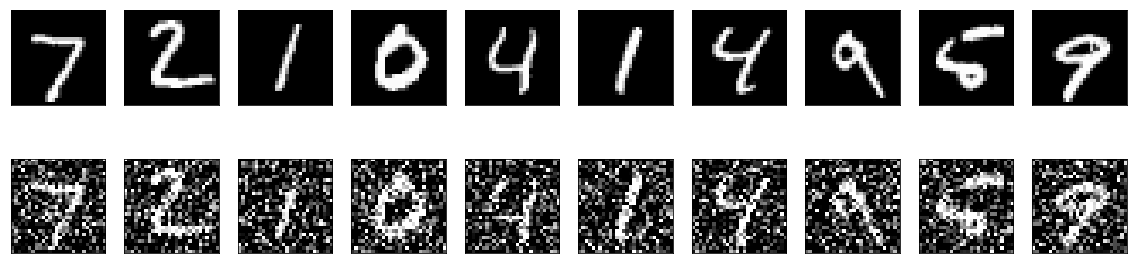

In [5]:
# Visualize the original vs noisy digit images
n = 10
plt.figure( figsize = (20, 5) )

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
for i in range(n):
    ax = plt.subplot(2, n, i+11)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [7]:
input_img = Input(shape = (28, 28, 1))
x         = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_img)
x         = MaxPooling2D((2, 2), padding = 'same')(x)
x         = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
encoded   = MaxPooling2D((2, 2), padding = 'same')(x)
# the representation is 7 * 7 * 32

x         = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(encoded)
x         = UpSampling2D((2, 2))(x)
x         = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x         = UpSampling2D((2, 2))(x)
decoded   = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(x)

# auto encoder model
ANNModel = Model(input_img, decoded)
ANNModel.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')

# encoder part of the model (also a model)
# it gets trained when ANNModel is trained (as it copies the NN and weights of ANNModel)
Encoder = Model(input_img, encoded)

In [8]:
history = ANNModel.fit(x                = x_train_noisy, 
                       y                = x_train,
                       epochs           = 10,
                       batch_size       = 128,
                       shuffle          = True,
                       validation_data  = (x_test_noisy, x_test)
                      )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 235s - loss: 0.2028 - val_loss: 0.1352
Epoch 2/10
60000/60000 [==============================] - 218s - loss: 0.1270 - val_loss: 0.1182
Epoch 3/10
60000/60000 [==============================] - 223s - loss: 0.1170 - val_loss: 0.1131
Epoch 4/10
60000/60000 [==============================] - 247s - loss: 0.1123 - val_loss: 0.1089
Epoch 5/10
60000/60000 [==============================] - 209s - loss: 0.1092 - val_loss: 0.1067
Epoch 6/10
60000/60000 [==============================] - 206s - loss: 0.1071 - val_loss: 0.1042
Epoch 7/10
60000/60000 [==============================] - 221s - loss: 0.1055 - val_loss: 0.1059
Epoch 8/10
60000/60000 [==============================] - 223s - loss: 0.1044 - val_loss: 0.1044
Epoch 9/10
60000/60000 [==============================] - 221s - loss: 0.1034 - val_loss: 0.1026
Epoch 10/10
60000/60000 [==============================] - 219s - loss: 0.102

['loss', 'val_loss']


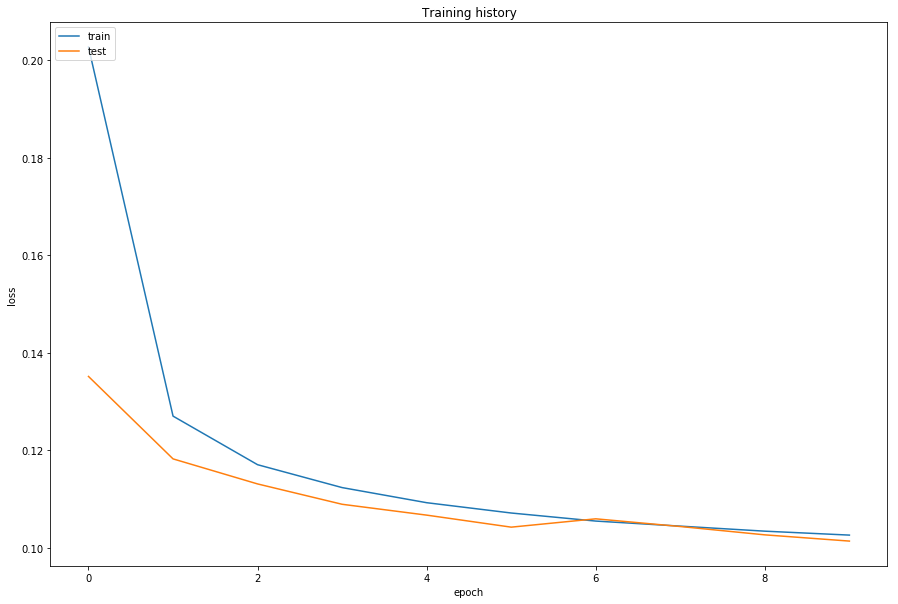

In [9]:
# Diplay the training history
print(history.history.keys())
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
# Denoising with auto encoder
decoded_imgs = ANNModel.predict(x_test_noisy[:10])

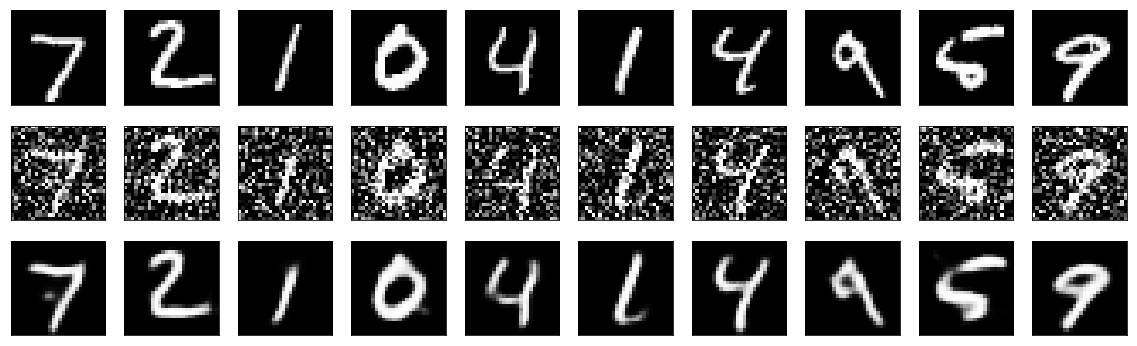

In [11]:
# Compare original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

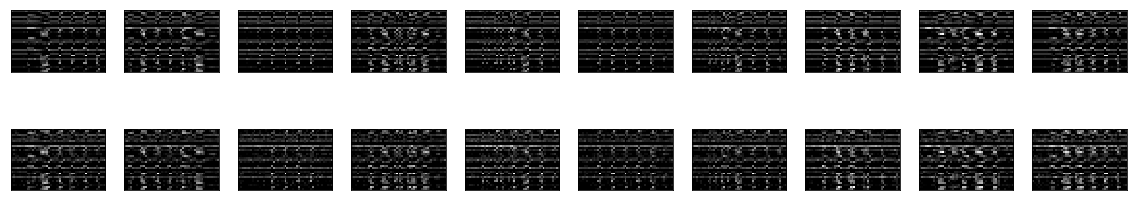

In [17]:
# Compare the encoding for the original and noisy images
encoded_imgs       = Encoder.predict(x_test[:10])
encoded_noisy_imgs = Encoder.predict(x_test_noisy[:10])

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # encoded images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(7*7, 32).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # encoded noisy images
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(encoded_noisy_imgs[i].reshape(7*7, 32).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()